In [8]:
cd /home/aayush/Documents/000/

/home/aayush/Documents/000


In [9]:
pwd

'/home/aayush/Documents/000'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from matplotlib import gridspec
import pickle
import time
import pandas
from PIL import Image
import pylab

from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual,HBox
import ipywidgets as widgets
from IPython.display import display

import scipy.signal as sig

%matplotlib inline

In [11]:
#Load CSV file and its values
gaze_positions=pandas.read_csv('./gaze_positions.csv')
world_timestamp=gaze_positions['world_timestamp']
world_index=gaze_positions['world_index'] 
confidence=gaze_positions['confidence']
norm_pos_x=gaze_positions['norm_pos_x']
norm_pos_y=gaze_positions['norm_pos_y'] 
base_data=gaze_positions['base_data']
gaze_point_3d_x=gaze_positions['gaze_point_3d_x'] 
gaze_point_3d_y=gaze_positions['gaze_point_3d_y']
gaze_point_3d_z=gaze_positions['gaze_point_3d_z']

eye_center0_3d_x=gaze_positions['eye_center0_3d_x'] 
eye_center0_3d_y=gaze_positions['eye_center0_3d_y']
eye_center0_3d_z=gaze_positions['eye_center0_3d_z'] 
gaze_normal0_x=gaze_positions['gaze_normal0_x'] 
gaze_normal0_y=gaze_positions['gaze_normal0_y']
gaze_normal0_z=gaze_positions['gaze_normal0_z'] 

eye_center1_3d_x=gaze_positions['eye_center1_3d_x'] 
eye_center1_3d_y=gaze_positions['eye_center1_3d_y']
eye_center1_3d_z=gaze_positions['eye_center1_3d_z'] 
gaze_normal1_x=gaze_positions['gaze_normal1_x'] 
gaze_normal1_y=gaze_positions['gaze_normal1_y']
gaze_normal1_z=gaze_positions['gaze_normal1_z']

In [12]:
#Converting it to degrees (Depth of Field is 60 degree and the screen resolution is 1280*720)
pos_x_deg=(norm_pos_x-0.5)*60
pos_y_deg=(norm_pos_y-0.5)*60*(720/1280)
frame_rate=120
length_to_process=1100 #(8 sec of video)

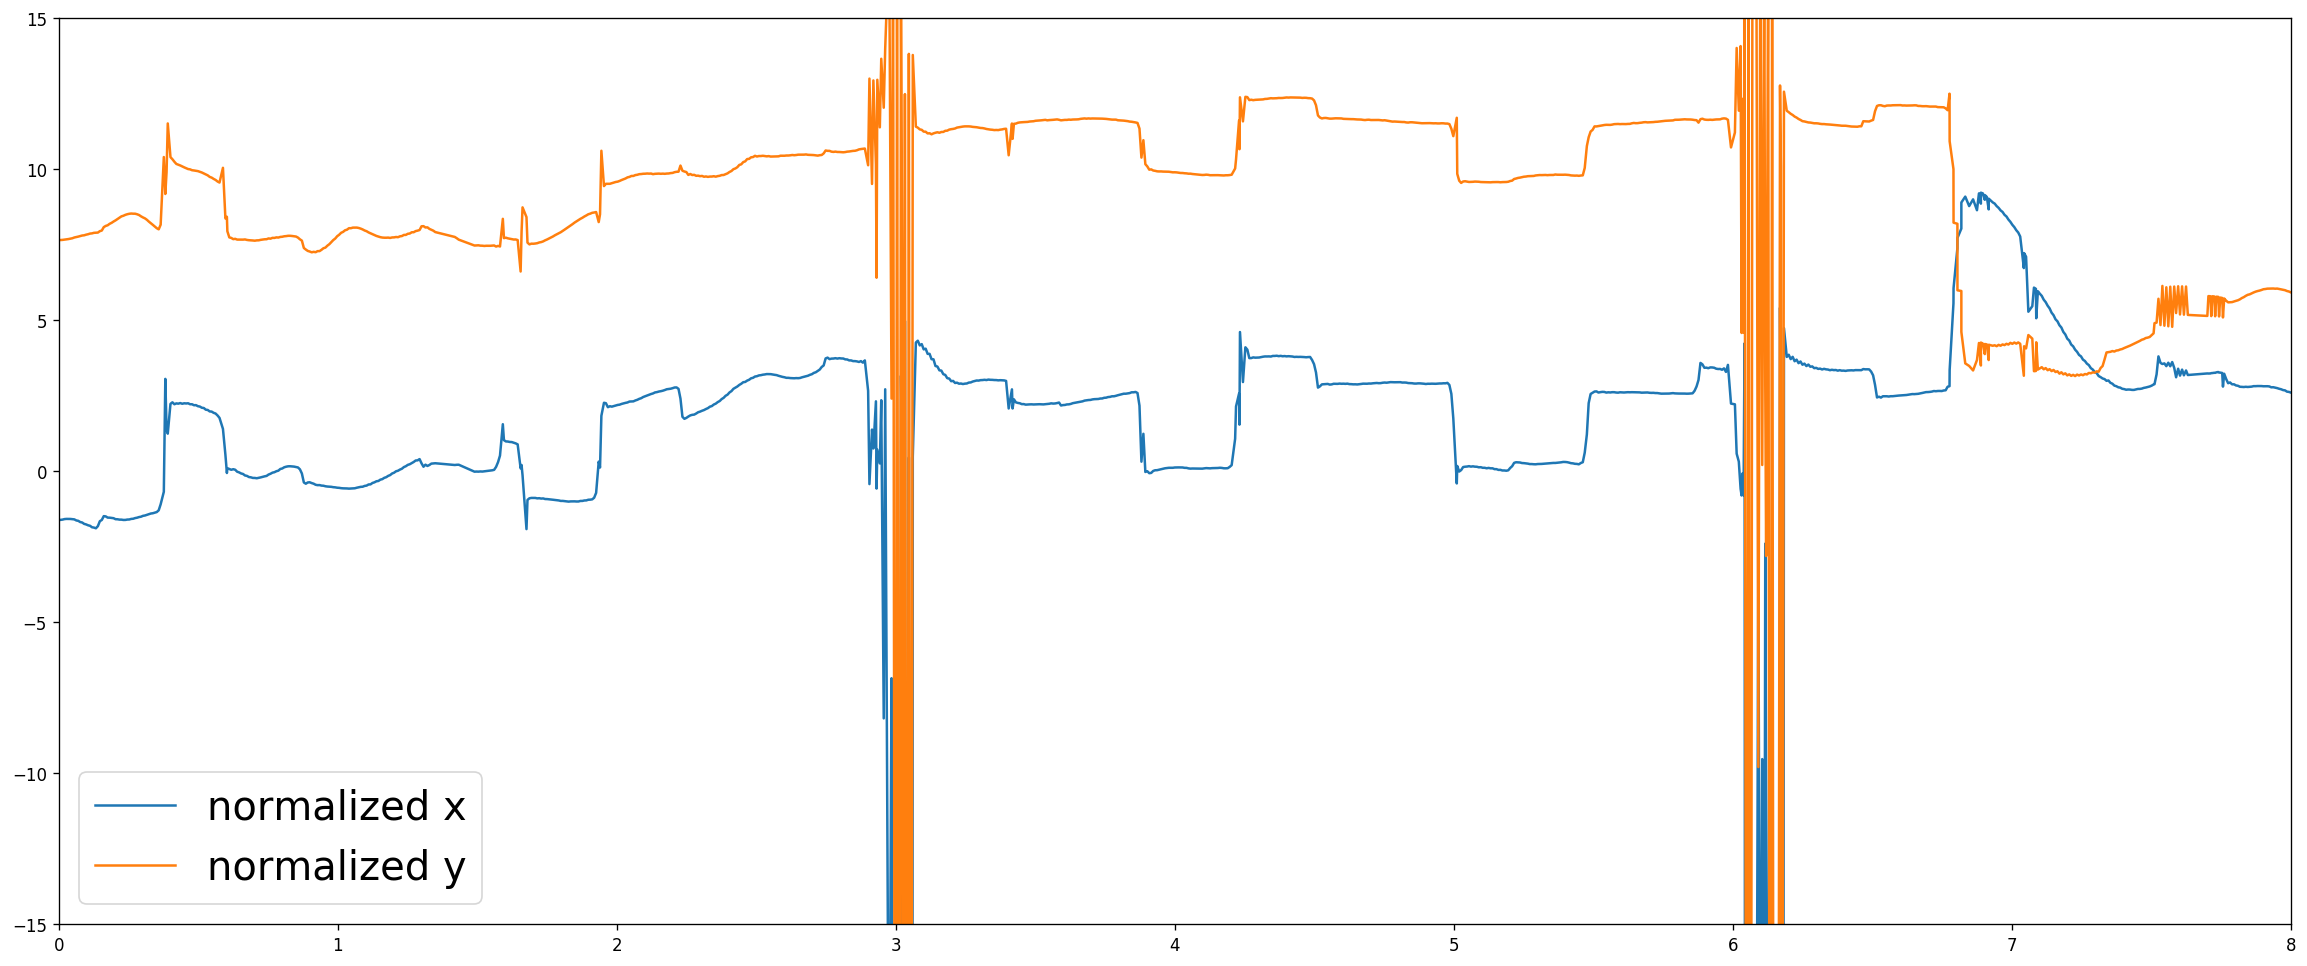

In [13]:
##visualize the postition signal
plt.figure(figsize=(24,10), dpi= 120)
plt.plot(world_timestamp-world_timestamp[0],pos_x_deg,label='normalized x')
plt.plot(world_timestamp-world_timestamp[0],pos_y_deg,label='normalized y')
plt.ylim([-15,15])
plt.xlim([0,8])
plt.legend(prop={'size': 24})

In [14]:
#computing the velocity (difference of position with respect to time)
def compute_velocity_consecutive(x_position,y_position,timestamp):
    x_velocity=np.append(0,np.abs(np.diff(x_position)/np.diff(timestamp)))
    y_velocity=np.append(0,np.abs(np.diff(y_position)/np.diff(timestamp)))
    Pythagorean_velocity=np.sqrt((np.square(x_velocity))+(np.square(y_velocity)))
    return x_velocity,y_velocity,Pythagorean_velocity
    
#hard thresholding IVT implementation
#saccade velocity input by the user
def IVT_hardthreshold(velocity,lowerlim_x,upperlim_x,saccade_threshold):
    idx=np.where((velocity)>saccade_threshold)
    
    #grouping the consecutive index of saccade eye movements so that it becomes easy for visualization.
    sequences = np.split(idx[0],np.array(np.where(np.diff(idx) > 1)[1]+1))
    l = []
    for s in sequences:
        if len(s) > 1:
            l.append((np.min(s), np.max(s)))
        else:
            l.append(s[0])
    return (l) 

#use of Gaussian mixture model for saccade threshold determination.
import itertools
from sklearn import mixture
from scipy import linalg
def noise_thresholdextract(data_input):
    #select only data whose value is less than 400 deg/sec.... Prefer to lower the values to about 20 deg/sec if the idea is to detect microsaccades
    idx=(data_input<400)
    gmm = mixture.GaussianMixture(n_components=2, covariance_type='full',
                          max_iter=100).fit(data_input[idx].reshape(-1, 1))    
    means=gmm.means_
    covariances=np.sqrt(gmm.covariances_)
    idd=np.argsort(means.reshape(2))
    value=float((means[idd[0]]+3*covariances[idd[0]])[0]) ##mean +3*std for noise signalS
    return (value)

#use of sliding window adaptive technique for IVT
def IVT_slidingwindow(velocity,lowerlim_x,upperlim_x,width_of_window):
    adjlen=3
    idx=[]
    for i in range (lowerlim_x,upperlim_x):
        #selecting saccade thresholding _using overall distribution for initial and final half width of window
        if i<(width_of_window/2) or (i+(width_of_window/2))>upperlim_x :  #for first half window and last half window compute overall threshold
            saccade_threshold=noise_thresholdextract(velocity)
        else:
            saccade_threshold=noise_thresholdextract(velocity[i-int((width_of_window/2)):i+int((width_of_window/2))])
        if velocity[i]>saccade_threshold:
            idx.append(i)
    #grouping the consecutive index of saccade eye movements so that it becomes easy for visualization.
    sequences = np.split(idx,np.array(np.where(np.diff(idx) > 1)[0]+1))
    l = []
    for s in sequences:
        if len(s) > 1:
            l.append((np.min(s), np.max(s)))
        else:
            l.append(s[0])
    return (l) 

def IDT_slidingwindow(position):
    window=[]
    window1=np.zeros((length_to_process))
    counter=0
    start=True
    current_window=[]
    for i in range (len(position)):
        if start:
            current_window=[]
            current_window.append(position[i])
        dispersion=np.abs(position[i]-np.mean(current_window))
        if (dispersion>3*np.abs(np.std(current_window))):
            print ('here')
            start=True
        else:
            if start==False:
                window.append([i])
                window1[counter]=i
                counter=counter+1
                current_window.append(position[i])
            start=False
    return window1

#returns the fixation points based on the dispersion.
def IDT_hardthreshold(position,dispersion_threshold=0.1):
    window=np.zeros((length_to_process))
    counter=0
    start=True
    current_window=[]
    for i in range (len(position)):
        if start:
            current_window=[]
            current_window.append(position[i])
        #dispersion is calculated based on the difference of current position with respect to mean of the window
        dispersion=np.abs(position[i]-np.mean(current_window))
        if (dispersion>dispersion_threshold):
            start=True
        else:
            if start==False:
                window[counter]=i
                counter=counter+1
                current_window.append(position[i])
            start=False
    idx=window
    sequences = np.split(idx,np.array(np.where(np.diff(idx) > 1)[0]+1))
    l = []
    for s in sequences:
        if len(s) > 1:
            l.append((np.min(s), np.max(s)))
        else:
            l.append(s[0])
    return (l) 


In [15]:
#to display large fontsizes in plt.. function
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

(0.0, 3.95, 15, 15)

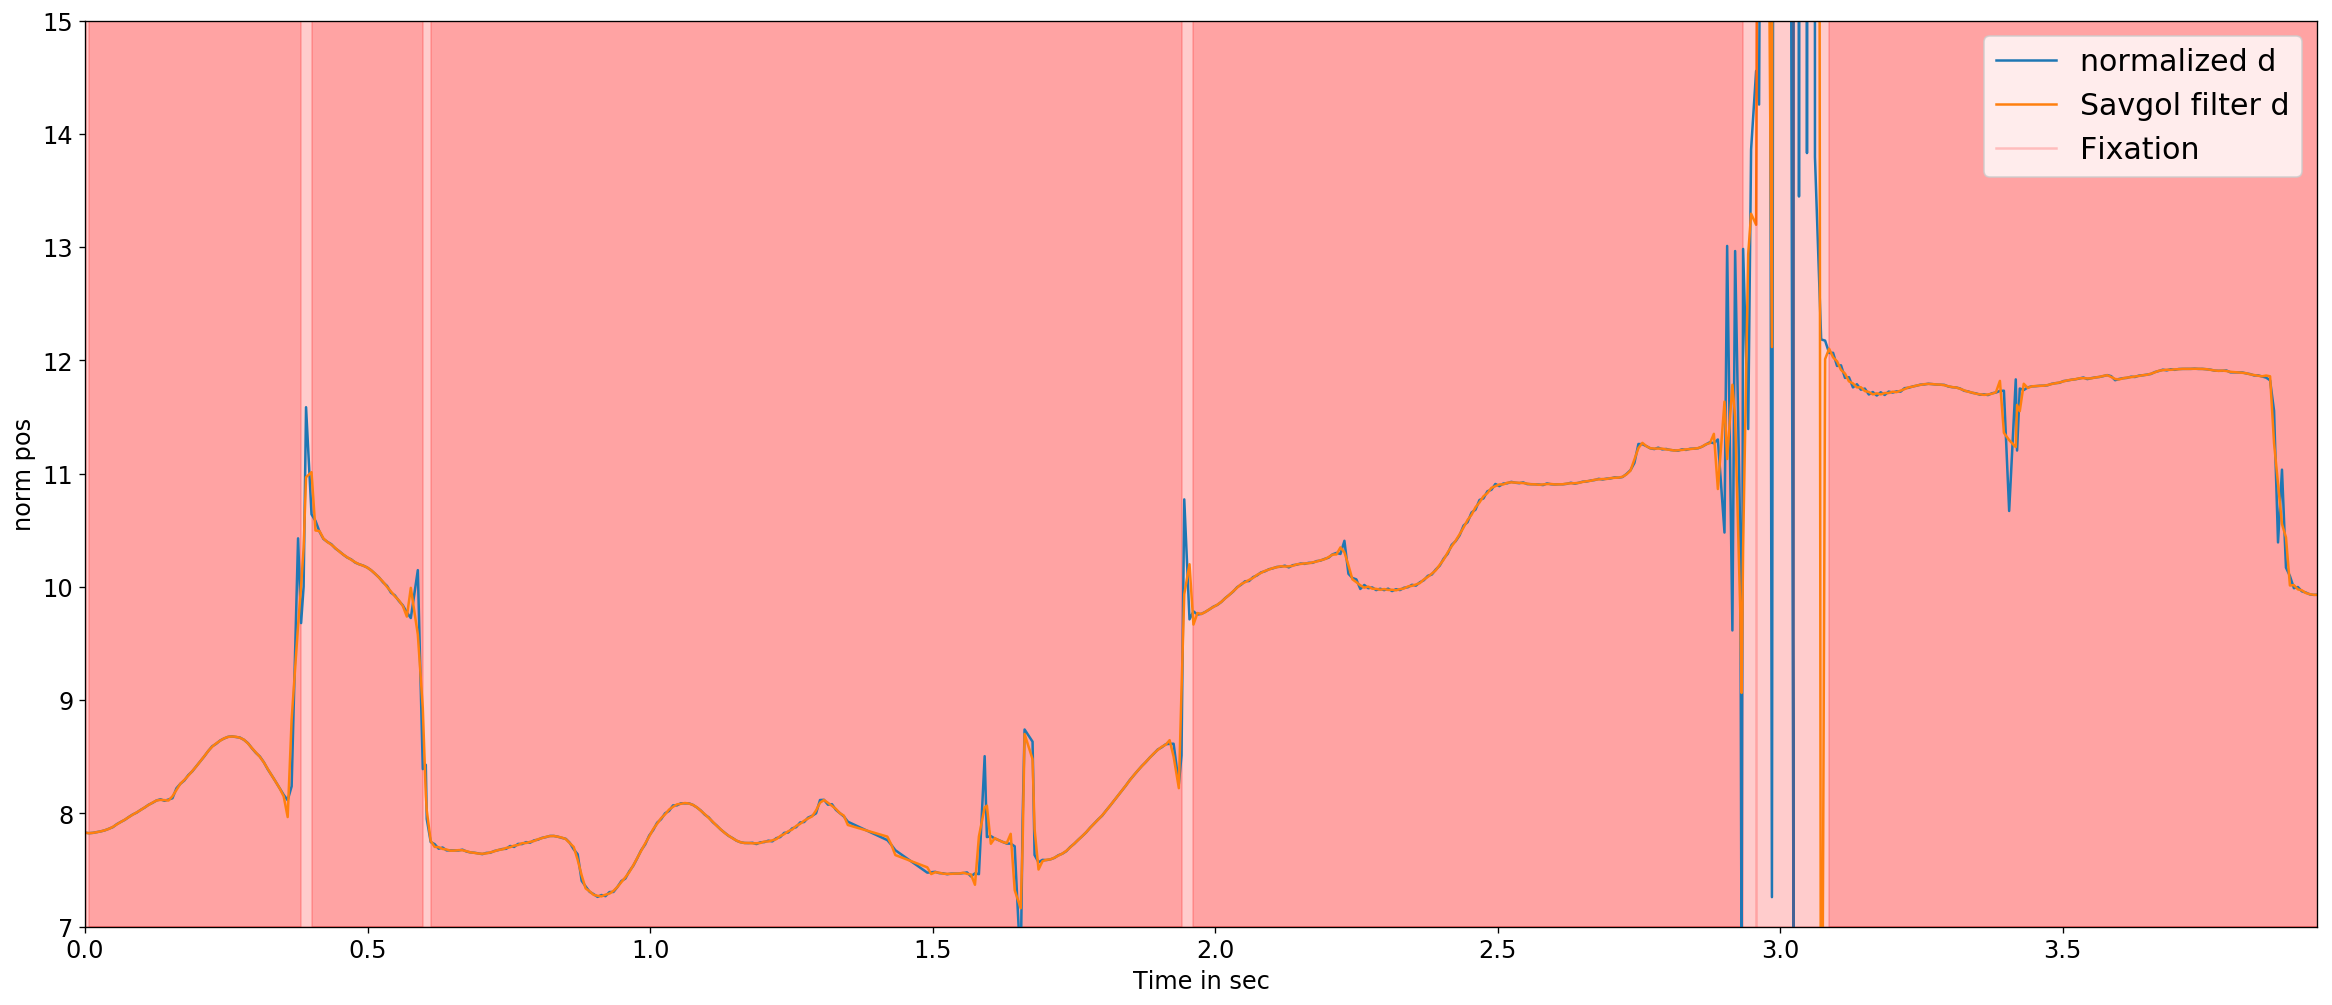

In [16]:
def func_gen(x_lim1,x_lim2,y_lim1,y_lim2,x_position_plot,y_position_plot,Pythogorean_position_plot,Median_filter,
              Savgol_filter,Median,Savgol_window,Savgol_order,IDT_compute,IDT_signal,dispersion_threshold):
    plt.figure(figsize=(24,10), dpi= 120)
    ax1=plt.subplot()
    
    pos_x=pos_x_deg[0:length_to_process]
    pos_y=pos_y_deg[0:length_to_process]
    #computing the Pythagorean position
    pos=np.sqrt((np.square(pos_x))+(np.square(pos_y)))
    timestamps=(world_timestamp-world_timestamp[0])[0:length_to_process]
    
    ##Filters data based on the choice of median filter of Savitzky Golay filter
    if x_position_plot:
        ax1.plot(timestamps,pos_x,label='normalized x')
        if Median_filter:
            ax1.plot(timestamps,sig.medfilt(pos_x,Median),label='Median filter-x')
        if Savgol_filter:
            ax1.plot(timestamps,sig.savgol_filter(pos_x,Savgol_window,Savgol_order),label='Savgol filter-x') 
    
    if y_position_plot:
        ax1.plot(timestamps,pos_y,label='normalized y')
        if Median_filter:
            ax1.plot(timestamps,sig.medfilt(pos_y,Median),label='Median filter-y')
        if Savgol_filter:
            ax1.plot(timestamps,sig.savgol_filter(pos_y,Savgol_window,Savgol_order),label='Savgol filter-y') 
    
    if Pythogorean_position_plot:
        ax1.plot(timestamps,pos,label='normalized d')
        if Median_filter:
            ax1.plot(timestamps,sig.medfilt(pos,Median),label='Median filter d')
        if Savgol_filter:
            ax1.plot(timestamps,sig.savgol_filter(pos,Savgol_window,Savgol_order),label='Savgol filter d') 

    if IDT_compute:
        if IDT_signal=='Original':
            new_idx=IDT_hardthreshold(pos,dispersion_threshold)
        if IDT_signal=='Median':
            new_idx=IDT_hardthreshold(sig.medfilt(pos,Median),dispersion_threshold)
        if IDT_signal=='Savgol':
            new_idx=IDT_hardthreshold(sig.savgol_filter(pos,Savgol_window,Savgol_order),dispersion_threshold)
        
        #visualization
        for z in ((new_idx)):
            if np.size(np.array(z))==1:
                ax1.axvline(np.float(timestamps[z]),color='r',alpha=0.2)
            else:
                x = [timestamps[z[0]],timestamps[z[0]], timestamps[z[1]], timestamps[z[1]]]
                y = [y_lim1,y_lim2,y_lim2,y_lim1]
                ax1.fill(x,y,color='r',alpha=0.2)
        ax1.axvline(0,color='r',alpha=0.2,label='Fixation')

    ax1.set_xlabel('Time in sec')
    ax1.set_ylabel('norm pos')
    ax1.set_xlim([x_lim1,x_lim2])
    
    ax1.set_ylim([y_lim1,y_lim2])
    ax1.legend(prop={'size': 18})
   # ax1.show()
    return (x_lim1,x_lim2,y_lim2,y_lim2)

p=interactive(func_gen,x_lim1=(0,8,0.05),x_lim2=(0,8,0.05), y_lim1=(-5,15,1), y_lim2=(-5,15,1),
              x_position_plot=False,y_position_plot=False,Pythogorean_position_plot=True,Median_filter=False,
              Savgol_filter=False,Median=(3,17,2),Savgol_window=(3,17,2),Savgol_order=(1,10,1),IDT_compute=False,
              IDT_signal=['Original','Median','Savgol'],dispersion_threshold=(0,4,0.05))

#systematic order of visualization 
display(HBox([p.children[0],p.children[2]]))
display(HBox([p.children[1],p.children[3]]))
display(HBox([p.children[4],p.children[5],p.children[6]]))
display(HBox([p.children[7],p.children[9]]))
display(HBox([p.children[8],p.children[10],p.children[11]]))
display(HBox([p.children[12],p.children[13],p.children[14]]))

(0.0, 3.95, 410, 410)

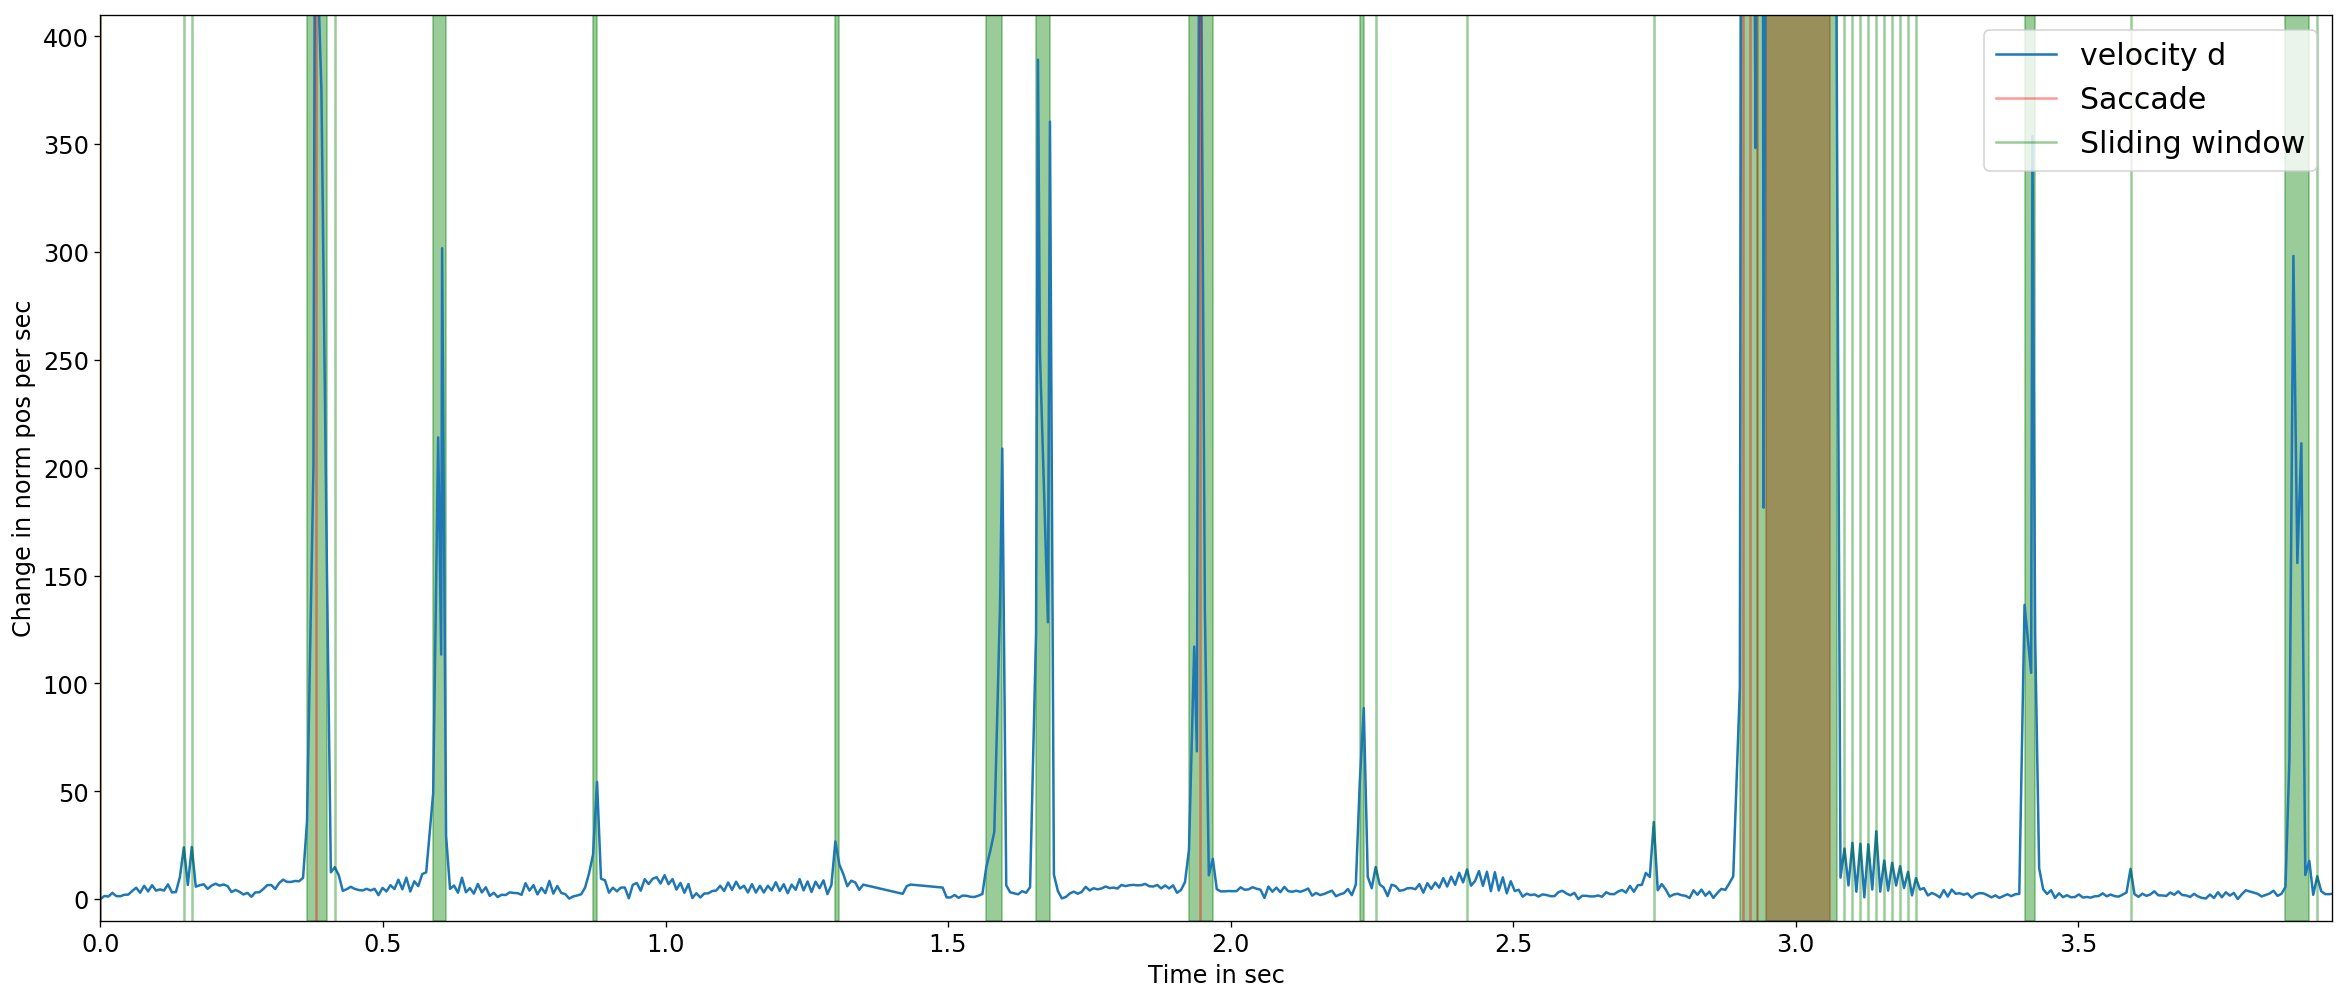

In [17]:
def func_gen(x_lim1,x_lim2,y_lim1,y_lim2,x_velocity_plot,y_velocity_plot,Pythogorean_velocity_plot,Median_filter,
              Savgol_filter,Median,Savgol_window,Savgol_order,IVT_compute_hard,IVT_signal,saccade_threshold,
            IVT_compute_slidingwindow,IVT_signal_sliding,sliding_window,position_plot):
    plt.figure(figsize=(24,10), dpi= 120)
    ax1=plt.subplot()
    
    pos_x=pos_x_deg[0:length_to_process]
    pos_y=pos_y_deg[0:length_to_process]
    timestamps=(world_timestamp-world_timestamp[0])[0:length_to_process]
    x_velocity,y_velocity,Pythagorean_velocity=compute_velocity_consecutive(pos_x,pos_y,timestamps)
    
    if x_velocity_plot:
        ax1.plot(timestamps,x_velocity,label='velocity x')
        if Median_filter:
            ax1.plot(timestamps,sig.medfilt(x_velocity,Median),label='Median filter-x')
        if Savgol_filter:
            ax1.plot(timestamps,sig.savgol_filter(x_velocity,Savgol_window,Savgol_order),label='Savgol filter-x') 
    
    if y_velocity_plot:
        ax1.plot(timestamps,y_velocity,label='velocity y')
        if Median_filter:
            ax1.plot(timestamps,sig.medfilt(y_velocity,Median),label='Median filter-y')
        if Savgol_filter:
            ax1.plot(timestamps,sig.savgol_filter(y_velocity,Savgol_window,Savgol_order),label='Savgol filter-y') 
    
    if Pythogorean_velocity_plot:
        ax1.plot(timestamps,Pythagorean_velocity,label='velocity d')
        if Median_filter:
            ax1.plot(timestamps,sig.medfilt(Pythagorean_velocity,Median),label='Median filter d')
        if Savgol_filter:
            ax1.plot(timestamps,sig.savgol_filter(Pythagorean_velocity,Savgol_window,Savgol_order),label='Savgol filter d') 

    if IVT_compute_hard:
        if IVT_signal=='Original':
            new_idx=IVT_hardthreshold(Pythagorean_velocity,0,1100,saccade_threshold)
        if IVT_signal=='Median':
            new_idx=IVT_hardthreshold(sig.medfilt(Pythagorean_velocity,Median),0,1100,saccade_threshold)
        if IVT_signal=='Savgol':
            new_idx=IVT_hardthreshold(sig.savgol_filter(Pythagorean_velocity,Savgol_window,Savgol_order),0,1100,saccade_threshold)
        
        
        for z in ((new_idx)):
            if np.size(np.array(z))==1:
                ax1.axvline(np.float(timestamps[z]),color='r',alpha=0.4)
            else:
                x = [timestamps[z[0]],timestamps[z[0]], timestamps[z[1]], timestamps[z[1]]]
                y = [y_lim1,y_lim2,y_lim2,y_lim1]
                ax1.fill(x,y,color='r',alpha=0.4)
        ax1.axvline(0,color='r',alpha=0.4,label='Saccade')
    
    if IVT_compute_slidingwindow:
        if IVT_signal_sliding=='Original':
            new_idx=IVT_slidingwindow(Pythagorean_velocity,0,1100,sliding_window)
        if IVT_signal_sliding=='Median':
            new_idx=IVT_slidingwindow(sig.medfilt(Pythagorean_velocity,Median),0,1100,sliding_window)
        if IVT_signal_sliding=='Savgol':
            new_idx=IVT_slidingwindow(sig.savgol_filter(Pythagorean_velocity,Savgol_window,Savgol_order),0,1100,sliding_window)
                
        for z in ((new_idx)):
            if np.size(np.array(z))==1:
                ax1.axvline(np.float(timestamps[z]),color='g',alpha=0.4)
            else:
                x = [timestamps[z[0]],timestamps[z[0]], timestamps[z[1]], timestamps[z[1]]]
                y = [y_lim1,y_lim2,y_lim2,y_lim1]
                ax1.fill(x,y,color='g',alpha=0.4)
        ax1.axvline(0,color='g',alpha=0.4,label='Sliding window')
        

    if position_plot:
        pos=np.sqrt((np.square(pos_x))+(np.square(pos_y)))
        ax1.plot(timestamps,(pos*20+50),label='position in degrees scaled version')

    ax1.set_xlim([x_lim1,x_lim2])
    ax1.set_ylim([y_lim1,y_lim2])
    ax1.legend(prop={'size': 18})
    ax1.set_xlabel('Time in sec')
    ax1.set_ylabel('Change in norm pos per sec')
    return (x_lim1,x_lim2,y_lim2,y_lim2)

p=interactive(func_gen,x_lim1=(0,8,0.05),x_lim2=(0,8,0.05), y_lim1=(-10,1500,10), y_lim2=(-10,1500,10),
              x_velocity_plot=False,y_velocity_plot=False,Pythogorean_velocity_plot=True,Median_filter=False,
              Savgol_filter=False,Median=(3,17,2),Savgol_window=(3,17,2),Savgol_order=(1,10,1),IVT_compute_hard=False,
              IVT_signal=['Original','Median','Savgol'],saccade_threshold=(0,1000,10),IVT_compute_slidingwindow=True,
             IVT_signal_sliding=['Original','Median','Savgol'],sliding_window=(0,240,5),position_plot=False)
    
              
#display(p)
display(HBox([p.children[0],p.children[2]]))
display(HBox([p.children[1],p.children[3]]))
display(HBox([p.children[4],p.children[5],p.children[6],p.children[18]]))
display(HBox([p.children[7],p.children[9]]))
display(HBox([p.children[8],p.children[10],p.children[11]]))
display(HBox([p.children[12],p.children[13],p.children[14]]))
display(HBox([p.children[15],p.children[16],p.children[17]]))